# Waterbody drought monitoring with Landsat 8

Author: Robbi Bishop-Taylor

In [12]:
# Supress Warning 
import warnings
warnings.filterwarnings('ignore')

import datacube
from rasterio.features import shapes
from shapely import geometry
import geopandas as gpd
from rasterstats import zonal_stats
import pandas as pd
from skimage import measure
from skimage import filters
import numpy as np
import matplotlib.pyplot as plt

from utils.data_cube_utilities.clean_mask import landsat_qa_clean_mask
from utils.data_cube_utilities.ama_utils.dc_display_map import display_map
from utils.data_cube_utilities.ama_utils.dc_water_classifier import wofs_classify
from utils.data_cube_utilities.ama_utils.dc_utilities import ignore_warnings

dc = datacube.Datacube(app = 'my_app', config = '/home/localuser/.datacube.conf')


## Set up analysis

In [2]:
platform = "LANDSAT_8"
product = "ls8_lasrc_tanzania"

In [578]:
# Area with water
# latitude_extents = (-3.24, -5.13)
# longitude_extents = (33.97, 36.6)
latitude_extents = (-4.48, -4.88)
longitude_extents = (34.64, 35.3)
time_extents = ('2013-01-01', '2018-11-01')

In [579]:
display_map(latitude_extents, longitude_extents)

## Import data for study area

In [221]:
landsat_dataset = dc.load(latitude = latitude_extents,
                          longitude = longitude_extents,
                          platform = platform,
                          product = product,
                          measurements = ['red', 'green', 'blue', 'nir', 'swir1', 'swir2', 'pixel_qa'], 
                          time = time_extents,
                          group_by = 'solar_day')
landsat_dataset


<xarray.Dataset>
Dimensions:    (latitude: 1475, longitude: 2435, time: 104)
Coordinates:
  * time       (time) datetime64[ns] 2013-04-28T07:51:55 ... 2017-12-19T07:50:21
  * latitude   (latitude) float64 -4.48 -4.48 -4.481 ... -4.879 -4.88 -4.88
  * longitude  (longitude) float64 34.64 34.64 34.64 34.64 ... 35.3 35.3 35.3
Data variables:
    red        (time, latitude, longitude) int16 1056 794 771 ... 1013 811 706
    green      (time, latitude, longitude) int16 914 763 740 725 ... 888 778 698
    blue       (time, latitude, longitude) int16 408 338 338 311 ... 514 397 364
    nir        (time, latitude, longitude) int16 3479 3502 3391 ... 3194 3175
    swir1      (time, latitude, longitude) int16 2827 2491 2472 ... 3151 2756
    swir2      (time, latitude, longitude) int16 1833 1506 1479 ... 2009 1589
    pixel_qa   (time, latitude, longitude) int32 322 322 322 322 ... 322 322 322
Attributes:
    crs:      EPSG:4326

### Mask out clouds

In [222]:
cloud_mask = landsat_qa_clean_mask(landsat_dataset, platform=platform)
cleaned_dataset = landsat_dataset.where(cloud_mask)
cleaned_dataset

<xarray.Dataset>
Dimensions:    (latitude: 1475, longitude: 2435, time: 104)
Coordinates:
  * time       (time) datetime64[ns] 2013-04-28T07:51:55 ... 2017-12-19T07:50:21
  * latitude   (latitude) float64 -4.48 -4.48 -4.481 ... -4.879 -4.88 -4.88
  * longitude  (longitude) float64 34.64 34.64 34.64 34.64 ... 35.3 35.3 35.3
Data variables:
    red        (time, latitude, longitude) float64 1.056e+03 794.0 ... 706.0
    green      (time, latitude, longitude) float64 914.0 763.0 ... 778.0 698.0
    blue       (time, latitude, longitude) float64 408.0 338.0 ... 397.0 364.0
    nir        (time, latitude, longitude) float64 3.479e+03 ... 3.175e+03
    swir1      (time, latitude, longitude) float64 2.827e+03 ... 2.756e+03
    swir2      (time, latitude, longitude) float64 1.833e+03 ... 1.589e+03
    pixel_qa   (time, latitude, longitude) float64 322.0 322.0 ... 322.0 322.0
Attributes:
    crs:      EPSG:4326

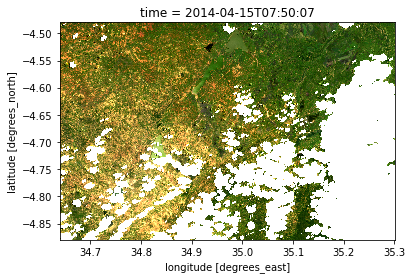

In [7]:
cleaned_dataset[['red', 'green', 'blue']].isel(time=20).to_array().plot.imshow(robust=True)

## Classify water using Water Observations From Space (WOFS) algorithm

In [223]:
wofs_arr = ignore_warnings(wofs_classify, cleaned_dataset).wofs
wofs_arr = wofs_arr.where(wofs_arr != -9999)
wofs_arr = wofs_arr.where(cloud_mask)
wofs_arr

<xarray.DataArray 'wofs' (time: 104, latitude: 1475, longitude: 2435)>
array([[[ 0.,  0., ...,  0.,  0.],
        [ 0.,  0., ...,  0.,  0.],
        ...,
        [ 0.,  0., ..., nan, nan],
        [ 0.,  0., ..., nan, nan]],

       [[ 0.,  0., ...,  0.,  0.],
        [ 0.,  0., ...,  0.,  0.],
        ...,
        [ 0.,  0., ..., nan, nan],
        [ 0.,  0., ..., nan, nan]],

       ...,

       [[ 0.,  0., ..., nan, nan],
        [ 0.,  0., ..., nan, nan],
        ...,
        [nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan]],

       [[ 0.,  0., ...,  0.,  0.],
        [ 0.,  0., ...,  0.,  0.],
        ...,
        [ 0.,  0., ...,  0.,  0.],
        [ 0.,  0., ...,  0.,  0.]]])
Coordinates:
  * time       (time) datetime64[ns] 2013-04-28T07:51:55 ... 2017-12-19T07:50:21
  * latitude   (latitude) float64 -4.48 -4.48 -4.481 ... -4.879 -4.88 -4.88
  * longitude  (longitude) float64 34.64 34.64 34.64 34.64 ... 35.3 35.3 35.3

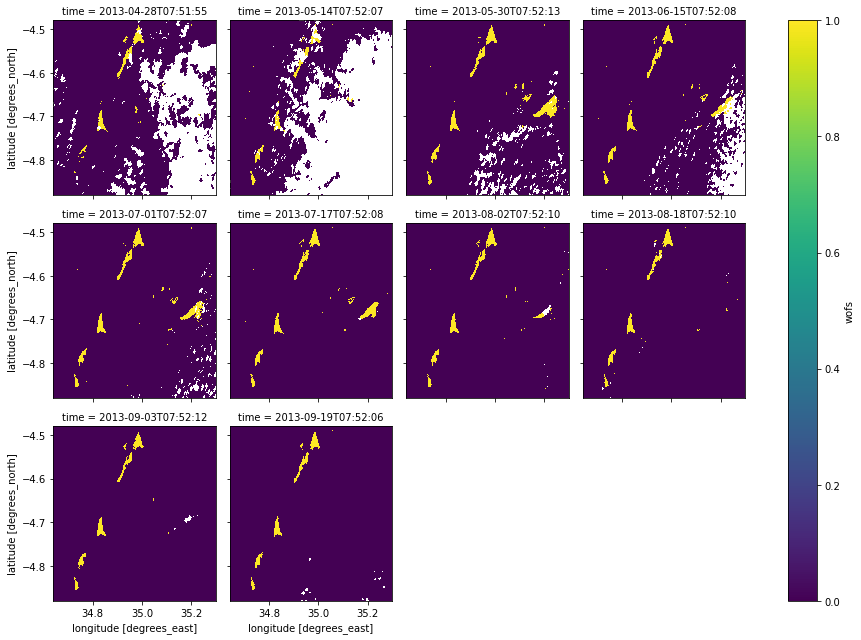

In [9]:
wofs_arr.isel(time=range(0, 10)).plot(col='time', col_wrap=4)

## Compute innundation frequency and max extent

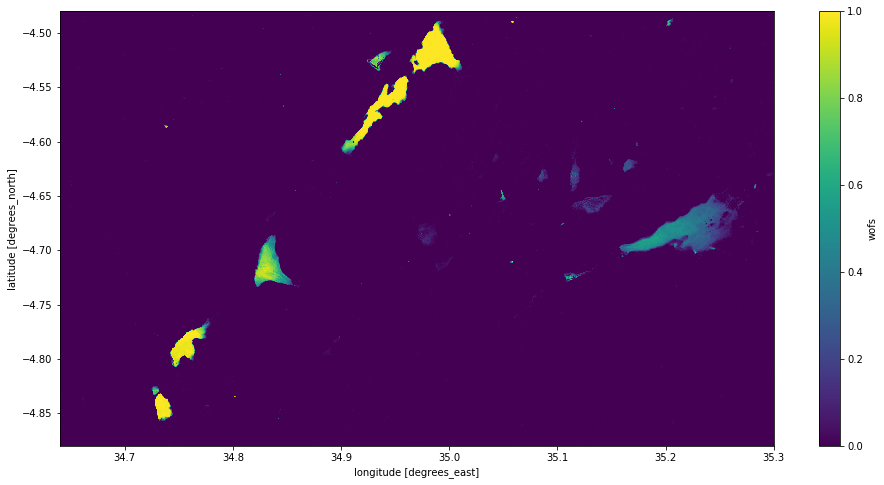

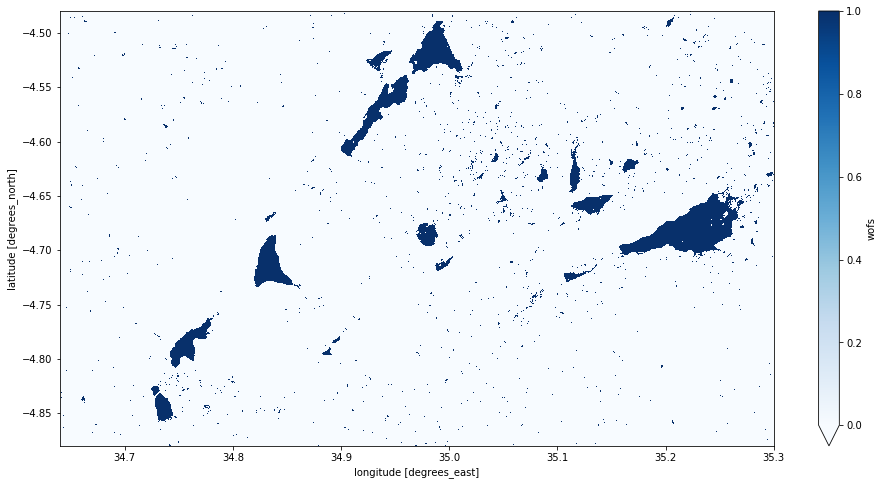

In [327]:
# Compute innundation frequency and max extent
wofs_freq = wofs_arr.mean(dim='time')
wofs_max = wofs_arr.max(dim='time').astype('int')

# Plot frequency
plt.figure(figsize=(16, 8))
wofs_freq.plot()

# Plot max extent
plt.figure(figsize=(16, 8))
wofs_max.plot(cmap='Blues', vmin=0, vmax=1.0)


## Vectorise max extent into discrete waterbodies

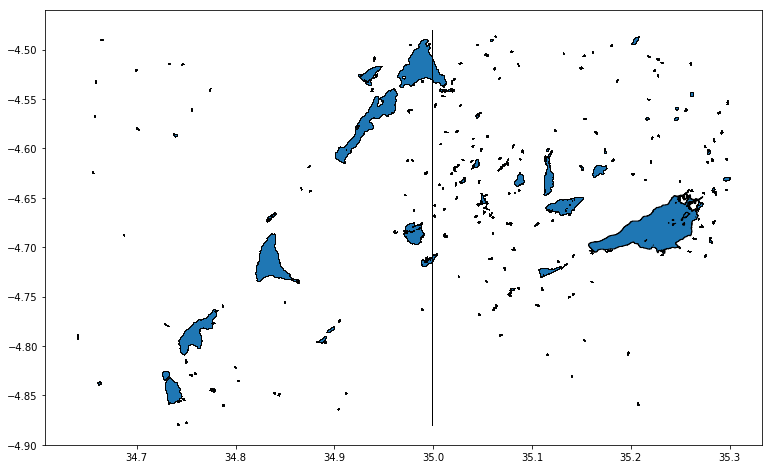

In [475]:
# Give each discrete waterbody a unique label
wofs_labelled = measure.label(wofs_max.values)

# Compute area of each unique waterbody. We can then use the unique
# waterbody labels to index into these values and create a spatial
# array where each waterbody has area values. To do this, we first 
# need to add 0 to the beginning of the array, so non-water pixels 
# with a label = 0 are assigned 0 area.
label_areas = [0] + [i.area for i in measure.regionprops(wofs_labelled)] 
wofs_area = np.array(label_areas)[wofs_labelled]

# Polygonise all features with sizes greater than 5
results = [{'properties': {'pixel_n': int(val)}, 
            'geometry': geo} for geo, val in 
           shapes(wofs_area.astype('int32'), transform=cleaned_dataset.geobox.affine, connectivity=8) if val > 20]

# Convert to geopandas dataframe
wofs_gpd = gpd.GeoDataFrame.from_features(results)
wofs_gpd['crs'] = 'EPSG:4326'
wofs_gpd = wofs_gpd.sort_values('pixel_n', ascending=False).reset_index(drop=True)
wofs_gpd['id'] = range(0, len(wofs_gpd))
wofs_gpd

# Save to file
wofs_gpd.to_file('GA_outputs/wofs_labelled.shp')

# Plot waterbodies
fig, ax = plt.subplots(figsize=(16, 8))
wofs_gpd.plot(edgecolor='black', ax = ax)

## Compute % fullness of each waterbody vs max extent for every timestep

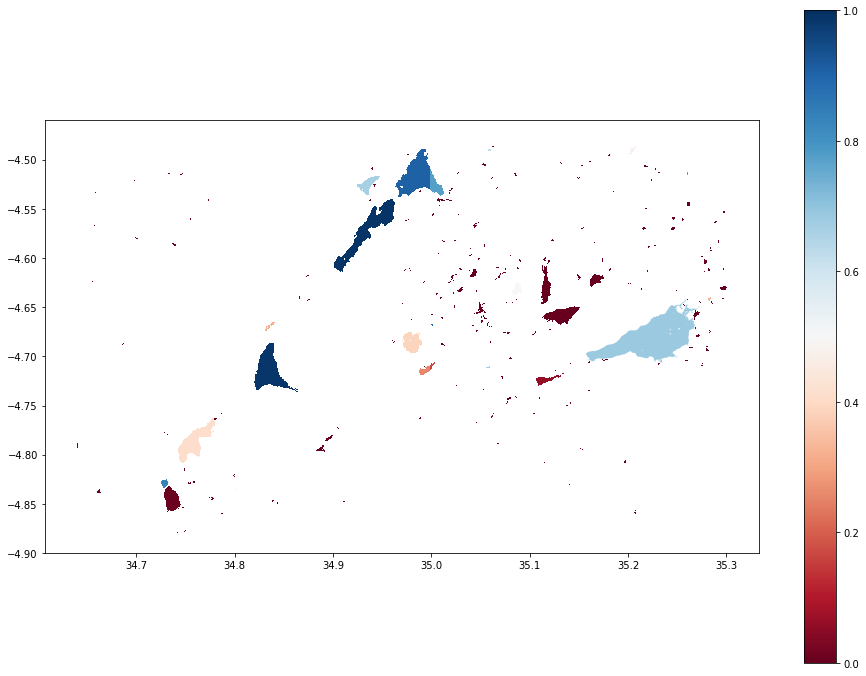

In [479]:
out = []

for time_i in wofs_arr.time:

    i = time_i.values.astype('str')[0:10]
    input_array = wofs_arr.sel(time = i).squeeze('time').values

    # Use Rasterstats to compute zonal statistics for all labelled polygons
    results = zonal_stats(vectors='GA_outputs/wofs_labelled.shp', 
                          raster=input_array, 
                          affine=cleaned_dataset.geobox.affine,
                          stats='mean',
                          prefix='{}_'.format(i))

    # Convert to a geopandas dataframe
    results_gpd = pd.DataFrame(results)
    out.append(results_gpd)

# Add to shapefile 
wofs_prop_gpd = pd.concat([wofs_gpd, *out], axis=1)

# Plot
fig, ax = plt.subplots(figsize=(16, 12))
first_col = wofs_prop_gpd.columns[4]
wofs_prop_gpd.plot(column=first_col, cmap='RdBu', vmin=0, vmax=1.0, ax=ax, legend=True)


## Plot full timeseries for a given waterbody

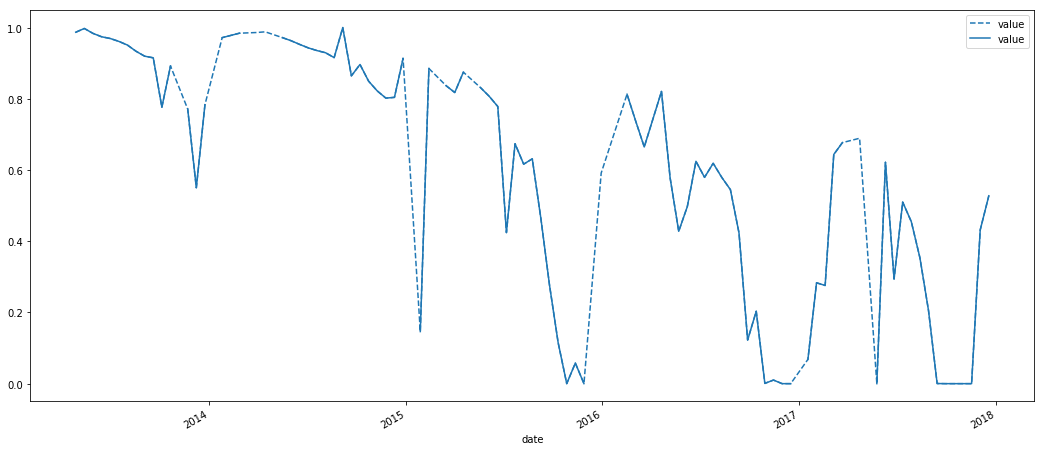

In [580]:
# Covert to long format
col_names = wofs_prop_gpd.columns[4:].values
wofs_prop_melted = wofs_prop_gpd.melt(id_vars=['id', 'pixel_n'], value_vars=col_names)
wofs_prop_melted['value'] = wofs_prop_melted.value.astype(float)
wofs_prop_melted

wofs_prop_melted['date'] = pd.to_datetime(wofs_prop_melted.variable.str.split('_', expand=True)[0])
wofs_prop_melted.sort_values(['date', 'id'])
wofs_prop_melted

# Plot one waterbody
waterbody_id = 3

fig, ax = plt.subplots(figsize=(18, 8))
selected_waterbody = wofs_prop_melted[wofs_prop_melted['id'] == waterbody_id]
selected_waterbody.interpolate(method='linear').plot(x='date', y='value', style='--', ax=ax, color='#1f77b4')
selected_waterbody.plot(x='date', y='value', ax=ax, color='#1f77b4')
selected_waterbody = wofs_prop_gpd[wofs_prop_gpd['id'] == waterbody_id]
display_map(selected_waterbody.geometry.bounds.iloc[0,[1, 3]],
            selected_waterbody.geometry.bounds.iloc[0,[0, 2]])
